In [1]:
# Import libraries
import requests
from io import StringIO
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from folium import Map, Choropleth, FeatureGroup, LayerControl, CircleMarker
from folium.features import GeoJsonTooltip
import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy.stats import poisson

In [2]:
# Set view options
pd.set_option('display.max_columns', 50)

#### 1\. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [3]:
# Retrieve aggravated burglary incidents between 1/1/21 and 6/30/21
soda_endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'
soda_params = {
    '$where': 'incident_reported between \'2021-01-01\' and \'2021-06-30\'',
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$limit': 10000
}
soda_response = requests.get(soda_endpoint, params = soda_params)

In [4]:
# Read in API query as geopandas dataframe
burglaries = gpd.read_file(StringIO(soda_response.text))
burglaries = burglaries.dropna(subset = ['geometry'])
burglaries.to_file('../data/aggravated_burglaries.geojson', driver = 'GeoJSON')
# burglaries.head()

#### 2\. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [5]:
# Read in census tracts shapefile as geopandas dataframe
census_tracts = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp').to_crs('EPSG:4326')
# census_tracts.head()

In [6]:
# Rename census tract column, filter census tracts in Davidson County, subset dataframe
census_tracts = census_tracts.rename(columns = {'TRACTCE': 'tract'})
census_tracts = census_tracts[census_tracts['COUNTYFP'] == '037'][['tract', 'geometry']]

In [7]:
# Perform spatial join of burglary incidents and census tracts dataframes
burglaries_by_tract = gpd.sjoin(burglaries, census_tracts, op = 'within')

In [8]:
# Display census tracts with highest number of burglaries
display(burglaries_by_tract.groupby('tract')['incident_number'].nunique().nlargest(5))

tract
016300    53
016200    21
011001    20
019300    19
019500    19
Name: incident_number, dtype: int64

#### 3\. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [9]:
# Read in census API key
with open('../data/census.json') as file:
    credentials = json.load(file)

api_key = credentials['api_key']

In [10]:
# Retrieve population data for census tracts in Davidson Country
detailed_endpoint = 'https://api.census.gov/data/2019/acs/acs5'
detailed_params = {
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
detailed_response = requests.get(detailed_endpoint, params = detailed_params)

In [11]:
# Read in API query as pandas dataframe, rename population column, convert column type to int
population = detailed_response.json()
population = pd.DataFrame(data = population[1:], columns = population[0])
population = population.rename(columns = {'B01001_001E': 'population'})
population['population'] = population['population'].astype(int)

In [12]:
# Retrieve median income data for census tracts in Davidson Country
subject_endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
subject_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
subject_response = requests.get(subject_endpoint, params = subject_params)

In [13]:
# Read in API query as pandas dataframe, rename median income column, convert column type to int
median_income = subject_response.json()
median_income = pd.DataFrame(data = median_income[1:], columns = median_income[0])
median_income = median_income.rename(columns = {'S1901_C01_012E': 'median_income'})
median_income['median_income'] = median_income['median_income'].astype(int)
median_income['median_income'] = median_income['median_income'].replace(-666666666, np.nan)

In [14]:
# Merge burglary incidents, population, and median income dataframes
dfs = [census_tracts, population, median_income]
census_tracts = reduce(lambda left, right: pd.merge(left, right), dfs)
burglaries_by_tract = gpd.sjoin(burglaries, census_tracts, op = 'within')

# Count unique burglary incidents per tract
burglaries_by_tract = burglaries_by_tract.groupby(by = ['tract', 'population', 'median_income'],
                                                as_index = False)['incident_number'].nunique()

# Rename burglaries column
burglaries_by_tract = burglaries_by_tract.rename(columns = {'incident_number': 'burglaries_count'})

# Calculate burglary rate and burglaries per 1000 residents
burglaries_by_tract['burglary_rate'] = burglaries_by_tract['burglaries_count'] / burglaries_by_tract['population']
burglaries_by_tract['burglaries_per_1000'] = burglaries_by_tract['burglary_rate'] * 1000

#### 4\. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [15]:
# Create dataframe for chloropleth map data
chloropleth_data = pd.merge(left = census_tracts, right = burglaries_by_tract, how = 'left')

# Write dataframe to geojson
chloropleth_data.to_file('../data/chloropleth_data.geojson', driver = 'GeoJSON')
chloropleth_data.head()

,tract,geometry,population,state,county,median_income,burglaries_count,burglary_rate,burglaries_per_1000
0,010106,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",3397,47,037,63864.0,7.0,0.002061,2.060642
1,010103,"POLYGON ((-86.91752 36.33976, -86.91747 36.339...",2533,47,037,70341.0,NaN,NaN,NaN
2,010202,"POLYGON ((-86.82482 36.33225, -86.82480 36.332...",3962,47,037,78750.0,NaN,NaN,NaN
3,010104,"POLYGON ((-86.97440 36.24991, -86.97244 36.252...",2955,47,037,64844.0,5.0,0.001692,1.692047
4,013300,"POLYGON ((-86.86843 36.16436, -86.86836 36.164...",3997,47,037,69006.0,12.0,0.003002,3.002252


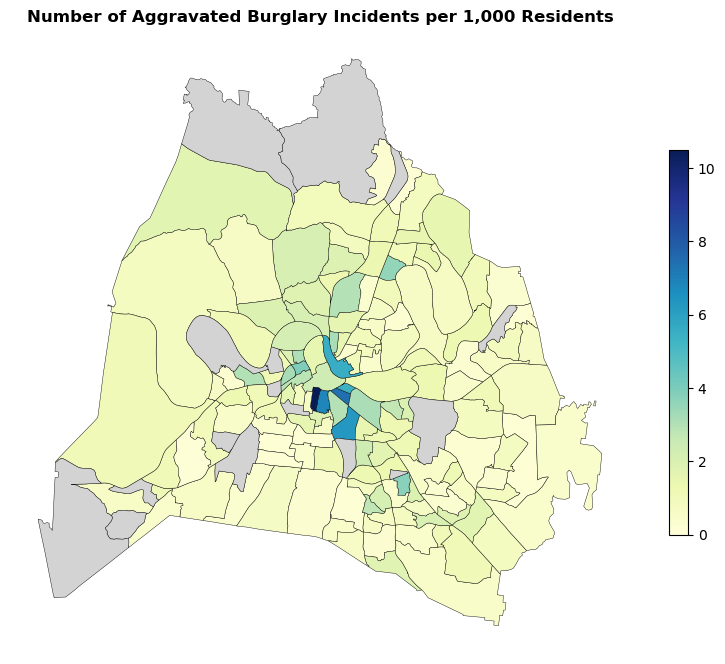

In [16]:
# Create chloropleth map with Matplotlib
fig, ax = plt.subplots(figsize = (10, 10))
plt.title('Number of Aggravated Burglary Incidents per 1,000 Residents', fontsize = 12, fontweight = 'bold')
ax.axis('off')

chloropleth_data.plot(column = 'burglaries_per_1000', 
                      cmap = 'YlGnBu',
                      missing_kwds = {'color': 'lightgrey'},
                      edgecolor = 'black', 
                      linewidth = 0.3,
                      vmin = 0,
                      vmax = 10.5,
                      ax = ax,
                      legend = True,
                      legend_kwds = {'shrink': 0.5}
                     );

plt.show()

In [17]:
# Create chloropleth map with Folium
map_ = Map(location = [36.1627, -86.7816],
           tiles = 'openstreetmap',
           min_zoom = 10)

map_chloropleth = Choropleth(
    geo_data = chloropleth_data,
    data = chloropleth_data,
    columns = ['tract', 'burglaries_per_1000'],
    key_on = 'feature.properties.tract',
    fill_color = 'YlOrRd',
    bins=[0, 1, 2, 5, 10, 21],
    nan_fill_color = 'lightgrey',
    fill_opacity = 0.65,
    line_color = 'black',
    line_weight = 0.1,
    line_opacity = 1,
    name = 'Choropleth Layer',
    legend_name = 'Aggravated Burglary Incidents per 1,000 Residents',
    highlight = True
).add_to(map_)

map_chloropleth.geojson.add_child(
    GeoJsonTooltip(fields = ['tract',
                             'burglaries_count',
                             'burglaries_per_1000',
                             'population',
                             'median_income'
                            ],
                   aliases = ['Census Tract:',
                              'Total Burglaries:',
                              'Burglaries per 1,000:',
                              'Population:',
                              'Median Income:'
                             ],
                   localize = True,
                  )
)

map_burglaries = FeatureGroup(name = 'Marker Layer', show = False)
map_burglaries.add_to(map_)
LayerControl().add_to(map_)

def plot_burglary(burglary):
    
    CircleMarker(location = [burglary.latitude, burglary.longitude],
                 radius = 2.5,
                 weight = 1,
                 fill_color = 'purple', 
                 fill_opacity = 0.75,
                 color = 'white',
                 tooltip = burglary.incident_location,
                ).add_to(map_burglaries)

burglaries.apply(plot_burglary, axis = 1)

map_.save('burglaries_map.html')
display(map_)

#### 5\. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the [Generalized Linear Models](https://www.statsmodels.org/stable/glm.html) module of the statsmodels library.

a\. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

In [18]:
# Create dataframe for model data
model_data = pd.merge(left = census_tracts, right = burglaries_by_tract, how = 'left')
model_data['burglaries_count'] = model_data['burglaries_count'].fillna(0)
model_data['burglary_rate'] = model_data['burglary_rate'].fillna(0)
model_data['burglaries_per_1000'] = model_data['burglaries_per_1000'].fillna(0)
model_data = pd.DataFrame(model_data.drop(columns = 'geometry').dropna())

# Write dataframe to csv
model_data.to_csv('../data/model_data.csv', index = False)
# model_data.head()

In [19]:
# Build Poisson base model
base_model = glm(formula = 'burglaries_count ~ 1', 
                 data = model_data, 
                 exposure = model_data.population / 1000, 
                 family = sm.families.Poisson()
                ).fit()

display(base_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -607.03
Date:                Mon, 11 Oct 2021   Deviance:                       734.57
Time:                        19:13:30   Pearson chi2:                 1.43e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          1.443e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1777      0.035      5.084      0.000       0.109       0.246
==============================================================================
"""

b\. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

In [20]:
# Build Poisson model with median income as predictor variable
poisson_model = glm(formula = 'burglaries_count ~ median_income', 
                    data = model_data,
                    exposure = model_data.population / 1000,
                    family = sm.families.Poisson()
                   ).fit()

display(poisson_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -532.63
Date:                Mon, 11 Oct 2021   Deviance:                       585.77
Time:                        19:13:30   Pearson chi2:                 1.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6124
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2995      0.100     13.046      0.000       1.104       1.495
median_income -1.881e-05    1.7e-06    -11.051      0.000   -2.22e-05   -1.55e-05
=================================================================================
"""

c\. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

In [21]:
# Build negative binomial model with median income as predictor variable
neg_binom_model = glm(formula = 'burglaries_count ~ median_income', 
                      data = model_data,
                      exposure = model_data.population / 1000,
                      family = sm.families.NegativeBinomial(alpha = 1)
                     ).fit()

display(neg_binom_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -424.91
Date:                Mon, 11 Oct 2021   Deviance:                       108.27
Time:                        19:13:30   Pearson chi2:                     201.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2021      0.223      5.380      0.000       0.764       1.640
median_income  -1.56e-05   3.32e-06     -4.696      0.000   -2.21e-05   -9.09e-06
=================================================================================
"""

d\. How do your models compare? Hint: the fit models have an AIC attribute.

In [22]:
# Compare AIC values
print(f'Base Model AIC: {round(base_model.aic, 2)}')
print(f'Poisson Model AIC: {round(poisson_model.aic, 2)}')
print(f'Negative Binomial Model AIC: {round(neg_binom_model.aic, 2)}')

Base Model AIC: 1216.06
Poisson Model AIC: 1069.25
Negative Binomial Model AIC: 853.82


In [23]:
# Compare dispersion ratios
base_model_dispersion = base_model.pearson_chi2 / base_model.df_resid
poisson_model_dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
neg_binom_model_dispersion = neg_binom_model.pearson_chi2 / neg_binom_model.df_resid

print(f'Base Model Dispersion Ratio: {round(base_model_dispersion, 2)}')
print(f'Poisson Model Dispersion Ratio: {round(poisson_model_dispersion, 2)}')
print(f'Negative Binomial Model Dispersion Ratio: {round(neg_binom_model_dispersion, 2)}')

Base Model Dispersion Ratio: 9.15
Poisson Model Dispersion Ratio: 7.03
Negative Binomial Model Dispersion Ratio: 1.3


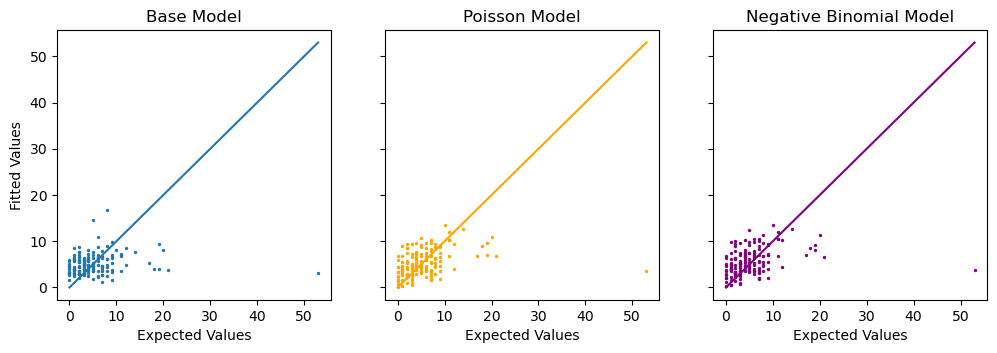

In [24]:
# Plot fitted vs. expected values
model_data['base_fit_values'] = base_model.fittedvalues
model_data['poisson_fit_values'] = poisson_model.fittedvalues
model_data['neg_binom_fit_values'] = neg_binom_model.fittedvalues

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

axs[0].scatter(model_data['burglaries_count'], model_data['base_fit_values'], s = 2)
axs[1].scatter(model_data['burglaries_count'], model_data['poisson_fit_values'], color = 'orange', s = 2)
axs[2].scatter(model_data['burglaries_count'], model_data['neg_binom_fit_values'], color = 'purple', s = 2)

axs[0].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])])
axs[1].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'orange')
axs[2].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'purple')

axs[0].title.set_text('Base Model')
axs[1].title.set_text('Poisson Model')
axs[2].title.set_text('Negative Binomial Model')

axs[0].set_xlabel('Expected Values')
axs[1].set_xlabel('Expected Values')
axs[2].set_xlabel('Expected Values')

axs[0].set_ylabel('Fitted Values')
axs[1].label_outer()
axs[2].label_outer()

plt.show()

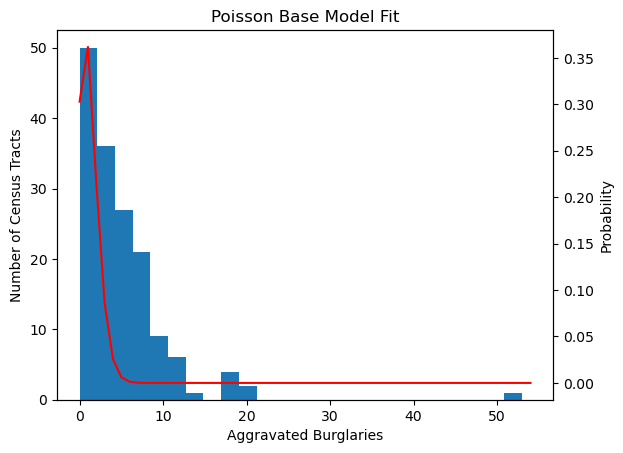

In [25]:
# Plot Poisson base model fit 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

intercept = base_model.params
x = np.arange(start = 0, stop = 55)
y = poisson.pmf(k = x, mu = np.exp(intercept))

ax1.hist(model_data['burglaries_count'], bins = 25)
ax2.plot(x, y, color = 'red')

ax1.title.set_text('Poisson Base Model Fit')
ax1.set_xlabel('Aggravated Burglaries')
ax1.set_ylabel('Number of Census Tracts')
ax2.set_ylabel('Probability')

plt.show()

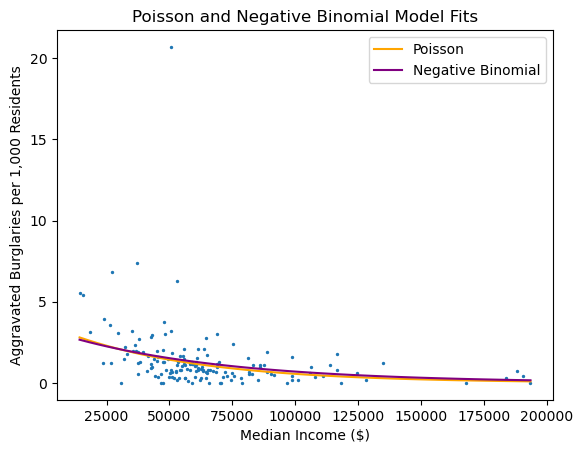

In [26]:
# Plot Poisson and negative binomial model fits
income_range = np.linspace(np.min(model_data['median_income']), np.max(model_data['median_income']))
poisson_fit = poisson_model.predict({'median_income': income_range})
neg_binom_fit = neg_binom_model.predict({'median_income': income_range})

model_data.plot(kind = 'scatter', x = 'median_income', y = 'burglaries_per_1000', s = 2)
plt.plot(income_range, poisson_fit, color = 'orange')
plt.plot(income_range, neg_binom_fit, color = 'purple')
plt.title('Poisson and Negative Binomial Model Fits')
plt.xlabel('Median Income ($)')
plt.ylabel('Aggravated Burglaries per 1,000 Residents')
plt.legend(['Poisson', 'Negative Binomial'])

plt.show()

#### 6\. Prepare a short presentation (<10 minutes) of your findings.

Additional Resources for Generalized Linear Models:
* DataCamp - [Generalized Linear Models in Python](https://learn.datacamp.com/courses/generalized-linear-models-in-python)
* [Beyond Multiple Linear Regression, Chapter 4](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html) Warning - the code in this book is all R, but the conceptual explanations are very clear.
* [This set of notes](https://apwheele.github.io/MathPosts/PoissonReg.html#negative-binomial-when-the-poisson-does-not-fit), which talks about the problem of overdispersion.